# Tutorial 1.b: Learning Uncertainty Representations from Data with Gradient Descent

In the previous tutorial we demonstrated several types of predictions and metrics to measure their quality. Naturally, given a quality measurement we can also optimize the predictions to maximize the quality measure. This tutorials demonstrates how to access the large number of inbuilt datasets in torchuq and use torchuq metrics to train a model on these datasets. 

Most of the tutorial will follow the standard deep learning pipeline. The only difference is that the torchuq metrics used as training objectives. In torchuq, most metrics are differentiable, so they can be directly used as objective functions and optimized with gradient descent. To see which metrics are differentiable see the reference list in [TBD]. 

### Setting up the Environment 

We first setup the environment of the tutorial. First load the necessary dependencies.

In [1]:
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

import sys
sys.path.append('../..')
import torchuq 

# device = torch.device('cuda:0')  # Use this option if you have GPU
device = torch.device('cpu')  

**Dataset**: We will use the UCI boston dataset. For your convenience torchuq includes a large collection of benchmark datasets with a single interface ``torchuq.dataset.regression.get_regression_datasets`` or ``torchuq.dataset.classification.get_classification_datasets``. All the data files are included with the repo, so you should be able to use these datasets out-of-the-box. For a list of available datasets see [link](https://github.com/ShengjiaZhao/torchuq/tree/main/torchuq/dataset). In addition to these simple datasets, there are also some larger datasets that require manual download of the data files. To access these datasets see [link]. 

An example usage to retrieve the simple datasets is

`` train_dataset, val_dataset, test_dataset = torchuq.dataset.regression.get_regression_datasets(dataset_name, val_fraction=0.2, test_fraction=0.2, split_seed=0) ``

You can split the data into train/val/test by setting non-zero values to the arguments ``val_fraction`` and ``test_fraction``. You can optionally specify the random seed used in the data splitting by `split_seed`. The return values are pytorch Dataset instances, which can be conveniently used with pytorch dataloaders. 

In [2]:
from torchuq.dataset.regression import get_regression_datasets
train_dataset, val_dataset, _ = get_regression_datasets('boston', val_fraction=0.2, test_fraction=0.0, verbose=True)

x_dim = len(train_dataset[0][0])   # Get the dimension of the input features
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)

# Get the validation features and labels and move them to correct device
val_x, val_y = val_dataset[:]    
val_x, val_y = val_x.to(device), val_y.to(device)

Loading dataset boston....
Splitting into train/val/test with 405/101/0 samples
Done loading dataset boston


**Prediction Model**: For simplicity, we use a 3 layer fully connected neural network as the prediction function. 

In [3]:
class NetworkFC(nn.Module):
    def __init__(self, x_dim, out_dim=1, num_feat=30):
        super(NetworkFC, self).__init__()
        self.fc1 = nn.Linear(x_dim, num_feat)
        self.fc2 = nn.Linear(num_feat, num_feat)
        self.fc3 = nn.Linear(num_feat, out_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc2(F.leaky_relu(self.fc1(x))))
        return self.fc3(x)

### Learning Probability Predictions

We can define a probability prediction model by mapping each input to the parameters of a distribution family (such as Gaussians). For example, the following code defines a prediction model that outputs Gaussian distributions. It is a network that outputs both the mean and standard deviation of the Gaussian distribution. 

In [4]:
net = NetworkFC(x_dim, out_dim=2).to(device)

pred_raw = net(val_x) 
pred_val = Normal(loc=pred_raw[:, 0], scale=pred_raw[:, 1].abs())

To learn the parameters of the prediction model, we can use any proper scoring rule. Recall from the previous tutorial: given a prediction $q$, and if the true label is $Y$ with (unknown) distribution $p_Y$, then a proper scoring rule is any function that satisfies $ \mathbb{E}[s(p_Y, Y)] \leq \mathbb{E}[s(q, Y)] $. Intuitively, predicting the correct distribution $q = p_Y$ minimizes the proper scoring rule. 

In our example we minimize the CRPS score. It could be replaced by the negative log likelihood (NLL) or any other proper scoring rule, and the results shouldn't be fundamentally changed. 

In [5]:
from torchuq.metric.distribution import compute_crps 

optimizer = optim.Adam(net.parameters(), lr=5e-4)

for epoch in range(50):
    # Evaluate the validation set performance
    if epoch % 10 == 0:    
        with torch.no_grad():  
            pred_raw = net(val_x) 
            pred_val = Normal(loc=pred_raw[:, 0], scale=pred_raw[:, 1].abs())
            loss = compute_crps(pred_val, val_y)  
            print("Epoch %d, loss=%.4f" % (epoch, loss))
    
    # Standard pytorch training loop
    for i, (bx, by) in enumerate(train_loader):  
        optimizer.zero_grad()
        pred_raw = net(bx.to(device)) 
        pred = Normal(loc=pred_raw[:, 0], scale=pred_raw[:, 1].abs())
        loss = compute_crps(pred, by.to(device)) 
        loss.backward()
        optimizer.step()


Epoch 0, loss=0.6452
Epoch 10, loss=0.3906
Epoch 20, loss=0.2858
Epoch 30, loss=0.2581
Epoch 40, loss=0.2463


We can visualize the predicted distributions on the validation set. These are the same functions that were introduced in the previous tutorial. 

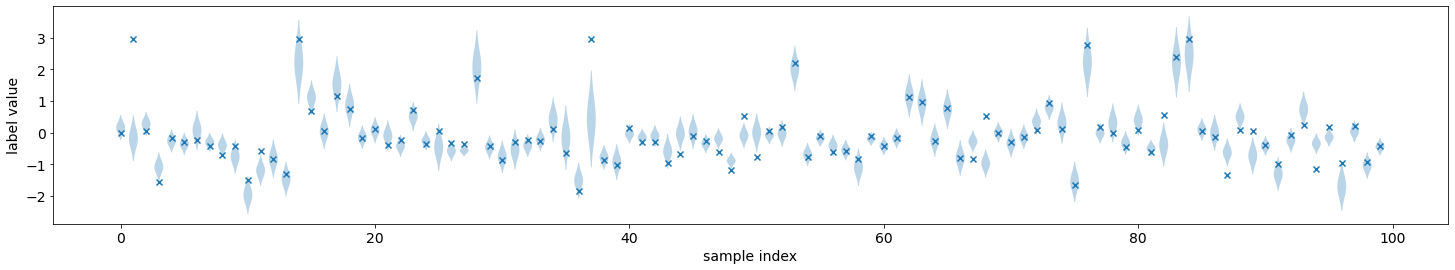

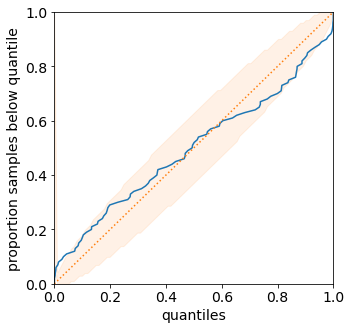

In [6]:
from torchuq.metric.distribution import plot_density_sequence, plot_reliability_diagram

# Record the quantile predictions on the validation set
pred_raw = net(val_x).detach() 
predictions_distribution = Normal(loc=pred_raw[:, 0], scale=pred_raw[:, 1].abs())

plot_density_sequence(predictions_distribution, val_y)
plot_reliability_diagram(predictions_distribution, val_y);

### Learning Quantile Predictions

Learning quantile predictions is very similar to learning distribution predictions. There are two differences: the prediction should have the correct shape ``[batch_size, n_quantiles]`` or ``[batch_size, n_quantiles, 2]``, and we must use a proper scoring rule for quantiles. For the proper scoring rule we use the pinball loss, which is minimized if and only if the predicted quantiles matches the true quantiles. 

In [7]:
from torchuq.metric.quantile import compute_pinball_loss

net = NetworkFC(x_dim, out_dim=10).to(device)
optimizer = optim.Adam(net.parameters(), lr=5e-4)

for epoch in range(50):
    # Evaluate the validation set performance
    if epoch % 10 == 0:    
        with torch.no_grad():  
            val_x, val_y = val_dataset[:]
            pred_val = net(val_x.to(device))
            loss = compute_pinball_loss(pred_val, val_y.to(device))
            print("Epoch %d, loss=%.4f" % (epoch, loss))
    
     # Standard pytorch training loop
    for i, (bx, by) in enumerate(train_loader): 
        optimizer.zero_grad()
        pred = net(bx.to(device))
        loss = compute_pinball_loss(pred, by.to(device))
        loss.backward()
        optimizer.step()

Epoch 0, loss=0.3223
Epoch 10, loss=0.2153
Epoch 20, loss=0.1654
Epoch 30, loss=0.1404
Epoch 40, loss=0.1325


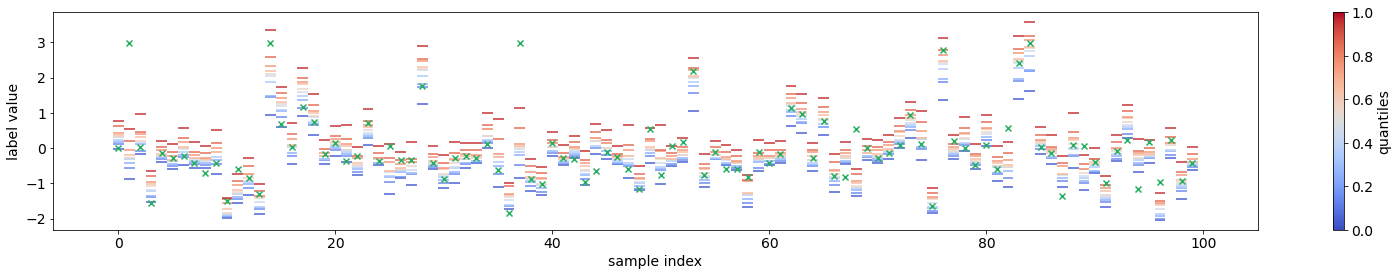

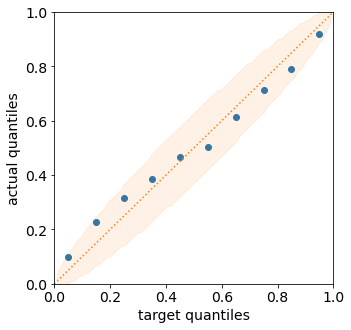

In [8]:
from torchuq.metric.quantile import plot_quantile_sequence, plot_quantile_calibration

# Record the quantile predictions on the validation set
predictions_quantile = net(val_x.to(device)).cpu().detach()

plot_quantile_sequence(predictions_quantile, val_y);
plot_quantile_calibration(predictions_quantile, val_y)

## Using Torchuq Transforms in an End-to-End Deep Learning Pipeline

One of the key functionality of Torchuq is **transformation**, i.e. converting a prediction into a different prediction. For example, a simple transformation is to convert a distribution prediction into an interval prediction. There is a very natural conversion: we simply take a credible interval of the predicted distribution. For a list of simple transformations see [TBD]. There are also sophisticated transformations (that we will introduce in the future tutorials), such as transforming ensemble predictions into calibrated distributions. 

In this tutorial we focus on end-to-end learning, and aim to show that most transformations in torchuq are differentiable, so can be incorporated into a deep learning pipeline as a network layer. 
As an example, the function ``torchuq.transform.direct.quantile_to_distribution`` converts a quantile prediction to a distribution prediction by fitting a kernel density estimator; it is a differentiable function. For demonstration purposes, we first predict a quantile prediction, then convert it to a distribution prediction, and finally optimize a proper scoring rule (negative log likelihood) on the distribution prediction. 

In [9]:
from torchuq.transform.direct import quantile_to_distribution
from torchuq.metric.distribution import compute_crps, compute_nll

net = NetworkFC(x_dim, out_dim=10).to(device)
optimizer = optim.Adam(net.parameters(), lr=5e-4)

for epoch in range(50):
    if epoch % 10 == 0:    # Evaluate the validation performance
        with torch.no_grad():  
            pred_raw = net(val_x.to(device)) 
            pred_val = quantile_to_distribution(pred_raw)

            loss = compute_nll(pred_val, val_y.to(device)) 
            print("Epoch %d, loss=%.4f" % (epoch, loss))
    
    for i, (bx, by) in enumerate(train_loader):  # Standard pytorch training loop
        optimizer.zero_grad()
        pred_raw = net(bx.to(device)) 
        pred_val = quantile_to_distribution(pred_raw)
        
        loss = compute_nll(pred_val, by.to(device))
        loss.backward()
        optimizer.step()

Epoch 0, loss=2.2140
Epoch 10, loss=1.1559
Epoch 20, loss=1.0283
Epoch 30, loss=1.1404
Epoch 40, loss=1.4565


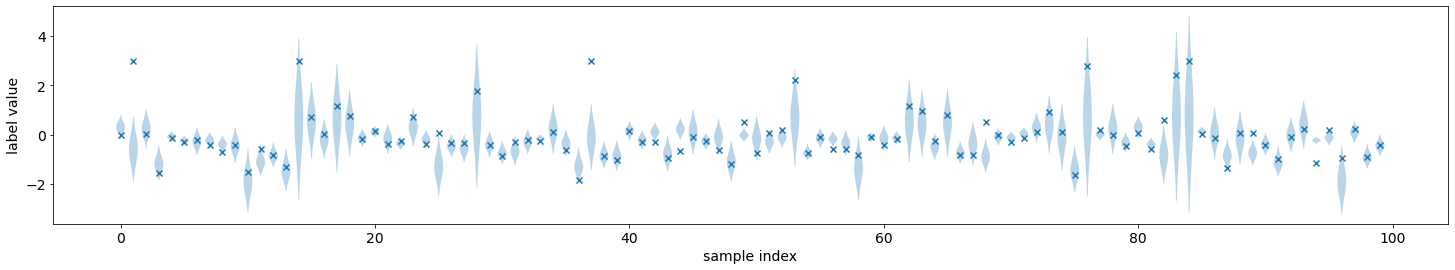

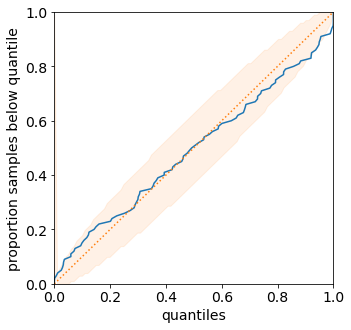

In [10]:
from torchuq.metric.distribution import plot_density_sequence, plot_reliability_diagram

pred_raw = net(val_x.to(device)).cpu()
predictions_distribution2 = quantile_to_distribution(pred_raw)

plot_density_sequence(predictions_distribution2, val_y)
plot_reliability_diagram(predictions_distribution2, val_y);